# NYC Covid Data with Compartmental (SIR,SIRD) Model Analysis and Tuning 

![title](img/covid.jpg)

## Introduction
Covid-19 is a kind of Coronavirus that has to date affected more than 2 million people worldwide and counting. With vaccines still being developed, specfic treatment still at the experimental stage, and limited testing capacity in much of the world, "social distancing" has emerged as the prevailing method of containment. Epidemiologic models used by public health officials have played a major role in convincing goverments to adopt this method. <br> <br> In this notebook, we first visualize the spread of Covid-19 in NYC by looking at the new case rate, hospitalization, and death rate as well as look at how they differ by gender, age, and race. We also look at some data on how much New Yorkers have heeded these calls to social dispancing and the timeframe. Finally, we try to fit some simple compartmental models such as SIR, and SIRD and validate for ourselves the impact of social distancing

In [138]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import PyPDF2
import re
from scipy.integrate import odeint


## Stats and visualizations on status and impact of Covid 19 in NYC

In [139]:
#get latest files containing case hospital deaths, by_sex and by_age data
nyc_file_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv"
download_file_chd = "./case-hosp-death.csv"
urllib.request.urlretrieve(nyc_file_url, download_file_chd)
nyc_by_sex_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/by-sex.csv"
download_file_bs = "./by_sex.csv"
urllib.request.urlretrieve(nyc_by_sex_url, download_file_bs)
nyc_by_age_url="https://raw.githubusercontent.com/nychealth/coronavirus-data/master/by-age.csv"
download_file_ba = "./by_age.csv"
urllib.request.urlretrieve(nyc_by_age_url, download_file_ba)

('./by_age.csv', <http.client.HTTPMessage at 0x1e07cd8bdc8>)

In [140]:
#get pdf file with race data on covid cases
nyc_by_race_url="https://www1.nyc.gov/assets/doh/downloads/pdf/imm/covid-19-deaths-race-ethnicity-04082020-1.pdf"
download_file_race="./covid-19-deaths-race-ethnicity-04082020-1.pdf"
urllib.request.urlretrieve(nyc_by_race_url, download_file_race)


('./covid-19-deaths-race-ethnicity-04082020-1.pdf',
 <http.client.HTTPMessage at 0x1e07cd8b188>)

In [141]:
def get_number_dead(race,line):
    search_substring = line.find(race)
    if search_substring!= -1:
        return float(re.findall(r'\d+\n',line[search_substring:])[0])

In [142]:
def get_text_race_table(fn):
    pdfFileObj = open(fn, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    # our file has just 1 page
    pageObj = pdfReader.getPage(0)
    pagecontent = pageObj.extractText()
    #table data after line 5
    lines = pagecontent.split(".",maxsplit=5)
    return lines[5]

In [143]:
#setup dataframe for covid rates by age,sex and the general case_hospitalization_death rate
by_age_df = pd.read_csv(download_file_ba)
by_sex_df = pd.read_csv(download_file_bs)
chd_df = pd.read_csv(download_file_chd)

In [144]:
#setup dict with covid death rate by race
covid_racial_death_rate_text = get_text_race_table(download_file_race)
race_labels = "All Hispanic;Non\n-Hispanic/Latino: Black, African \nAmerica\nn;\
 Non\n-Hispanic/Latino: White;Non\n-Hispanic/Latino: Asian;Non\n-Hispanic/Latino: Other;\
Total \nUnknown \nRace/\nEthnicity"
by_race_dict = {}
for index,race in enumerate(race_labels.split(";")):
    num_dead = get_number_dead(race,covid_racial_death_rate_text )
    by_race_dict[race] = num_dead

In [145]:
def drop_last_row(df):
    df.drop(df.tail(1).index, inplace = True)

In [146]:
def define_cumulative_case_sum(df, case_col):
    cum_case_col = "CUMULATIVE " + case_col
    df[cum_case_col] = df[case_col].cumsum()

In [147]:
def plot_rate(df, xcol,ycol,plot_title="NYC rate"):
    fig = px.bar(df, x=xcol, y=ycol, labels={'x':'DATE'})
    fig.update_layout(title=plot_title)
    fig.show()

In [148]:
def plot_pie(df, values_col, names_col, plot_title="NYC Age/Sex Covid Rate"):
    fig = px.pie(df, values = values_col, names = names_col, title=plot_title)
    fig.show()

In [149]:
#Preprocessing
#Fill unavailable data with 0
by_age_df.fillna(0)
by_sex_df.fillna(0)
chd_df.fillna(0)
define_cumulative_case_sum(chd_df,"NEW_COVID_CASE_COUNT" )
define_cumulative_case_sum(chd_df,"HOSPITALIZED_CASE_COUNT" )
define_cumulative_case_sum(chd_df,"DEATH_COUNT" )
# Needed to access DATE OF INTEREST as column
mod_bs = by_sex_df.reset_index()
mod_ba = by_age_df.reset_index()
mod_chd = chd_df.reset_index()
# Needed to remove citywide totals before pie plot generation
drop_last_row(mod_bs)
drop_last_row(mod_ba)
#generate necessary dataframe from race dictionary
mydict = {}
mydict["Race Label"]=list(by_race_dict.keys())
mydict["Number dead"]=list(by_race_dict.values())
by_race_df = pd.DataFrame.from_dict(mydict)

In [150]:
plot_rate(mod_chd,"DATE_OF_INTEREST","NEW_COVID_CASE_COUNT", "NYC Covid New Case Rate")

In [151]:
mod_chd["DATE_OF_INTEREST"]
mod_chd.iloc[4, :]

index                                      4
DATE_OF_INTEREST                      3/7/20
NEW_COVID_CASE_COUNT                       7
HOSPITALIZED_CASE_COUNT                   10
DEATH_COUNT                              NaN
CUMULATIVE NEW_COVID_CASE_COUNT           23
CUMULATIVE HOSPITALIZED_CASE_COUNT        52
CUMULATIVE DEATH_COUNT                   NaN
Name: 4, dtype: object

In [152]:
plot_rate(mod_chd,"DATE_OF_INTEREST","CUMULATIVE NEW_COVID_CASE_COUNT", "NYC Cumulative Covid Case Rate")

In [153]:
plot_rate(mod_chd,"DATE_OF_INTEREST","HOSPITALIZED_CASE_COUNT", "NYC Covid Hospitalized Case Rate")

In [154]:
plot_rate(mod_chd,"DATE_OF_INTEREST","CUMULATIVE HOSPITALIZED_CASE_COUNT", "NYC Cumulative Covid Hospitalisation Rate")

In [155]:
plot_rate(mod_chd,"DATE_OF_INTEREST","DEATH_COUNT", "NYC Covid Death Rate")

In [156]:
plot_rate(mod_chd,"DATE_OF_INTEREST","CUMULATIVE DEATH_COUNT", "NYC Cumulative Covid Death Rate")

In [157]:
plot_pie(mod_bs, "COVID_CASE_RATE","SEX_GROUP","NYC Covid Case Rate By Gender")

In [158]:
plot_pie(mod_bs, "HOSPITALIZED_CASE_RATE","SEX_GROUP","NYC Covid Hopitalized Case Rate By Gender")

In [159]:
plot_pie(mod_bs, "DEATH_RATE","SEX_GROUP", "NYC Covid Death Rate by Sex")

In [160]:
plot_pie(mod_ba, "COVID_CASE_RATE","AGE_GROUP", "NYC Covid Case Rate by Age")

In [161]:
plot_pie(mod_ba, "HOSPITALIZED_CASE_RATE","AGE_GROUP", "NYC Hospitalization Case Rate by Age")

In [162]:
plot_pie(mod_ba, "DEATH_RATE","AGE_GROUP", "NYC Covid Death Rate by Age")

In [163]:
plot_pie(by_race_df,"Number dead","Race Label", "NYC Covid Death Rate by Race")

## NYC Social distancing scorecard by date

Mobile data can be used to create a "social distancing scoreboard" to "measure and understand the efficacy of social distancing initiatives". One such scoreboard is made available by Unacast which we will use.

We derived the following table from their graph when we searched by the state of New York and match against the infected case count from the section above. <br>


<table>
    <tr>
        <th> <center> Date </center> </th>
        <th> <center> Social distancing grade </center> </th>
        <th> <center> Cumulative infected casecount </center> </th>
    </tr>
    <tr> 
        <td> 2020-02-29</td>
        <td> F </td>
        <td> 0 </td>
    </tr>
    <tr> 
        <td> 2020-03-07</td>
        <td> F </td>
        <td> 23 </td>
    </tr>
    <tr> 
        <td> 2020-03-14</td>
        <td> D </td>
        <td> 1931 </td>
    </tr>
    <tr> 
        <td> 2020-03-21</td>
        <td> C </td>
        <td> 20595 </td>
    </tr>
    <tr> 
        <td> 2020-03-28</td>
        <td> B </td>
        <td> 48924 </td>
    </tr>
    <tr> 
        <td> 2020-04-04</td>
        <td> B </td>
        <td> 83033 </td>
    </tr>
    <tr> 
        <td> 2020-04-11</td>
        <td> B </td>
        <td> 116408 </td>
    </tr>
    <tr> 
        <td> 2020-04-18</td>
        <td> B </td>
        <td> 132456 </td>
    </tr>
</table>

## SIR Model and Tuning

The SIR or **S**usceptible - **I**nfectious - **R**ecovered Model is an epidemiologic model that divides the total population, **N** in 3 camps.
* Susceptible individuals who may yet be infected
* Infectious individuals or carriers who are currently distributing the dosease
* Recovered individuals who have recovered and developed immunity

The change in susceptible individuals per unit time, is attributed to the "newly infected" and modeled by <br>
> dSdt = *-beta S I / N* <br>
where beta is the rate of communication of the disease, in turn influenced by
* contact rate of infectious individuals
* probability of disease transmission

The change in recovered individuals per unit time, or the "newly recovered" is modeled by <br>
> dRdt = *gamma I* <br>
where gamma is the recovery rate determined as 1/ #number of days needed to recover <br>

The change in infectious individuals in unit time then is the sum of the newly infected minus the newly recovered
> dIdt = *beta S I /N - gamma I* <br>

Here to estimate gamma we go by the reported median time from onset to clinical recovery for mild cases which is approximately 2 weeks and is 3-6 weeks for patients with severe or critical disease. We assume 80% cases are mild.


In [172]:
def plotCaseRate(plotS = False, plotI = False, plotR = False, plotD=False, start="03-02-2020t00:00"):
    datetime_col = pd.date_range(start, periods=len(t), freq="D")
    fig = plt.figure(facecolor = 'w')
    ax = fig.add_subplot(111, axisbelow = True)
    # replacing t with datetime_col.date in ax.plot
    if plotS:
        ax.plot(datetime_col.date, S, 'b', alpha=0.5, lw=2, label = "Susceptible")
    if plotI:
        ax.plot(datetime_col.date, I, 'r', alpha=0.5, lw=2, label = "Infected")
    if plotR:
        ax.plot(datetime_col.date, R, 'g', alpha=0.5, lw=2, label = "Recovered")
    if plotD:
        ax.plot(datetime_col.date, D, 'o', alpha=0.5, lw=2, label = "Dead")
    ax.set_xlabel('Time/days')
    ax.set_ylabel('Number of people')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which = 'major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()   

In [173]:
N = 8.7 * 1000000 # population of NYC 
I0, R0 = 1,0
S0 = N - I0 - R0
# contact rate - guesstimate start at 0.2,1.0, 0.6
# recovery rate - 2 weeks for 80 % and 3 to 6 weeks for 20 % approx 17 days
beta, gamma = 0.2, 1./17
# Time points in days
t = np.linspace(0,60, 60)

In [174]:
def derivSIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

We know that there are about 130000 infected in about 45 days, so playing around with the beta values leads us to use beta=0.35 and the infected chart below.Also the estimated infected is around 4 million by the end of April. However, this rate of infection seems to be too high right now as we can see the cumulative case counts levelling off in the section above. Perhaps we can do better by trying to work in the impact of social distancing - viz, its success in curbing the beta. Lets try again, but this time, starting after 03/21 when we had 20595 infected. <br>

For the recovered count we guesstimate that a third of cases are recovered . Currently, from https://www.worldometers.info/coronavirus/country/us/ we see that of the closed cases almost 2/3rd are recovered, and the closed cases are themselves about 10% of the total cases

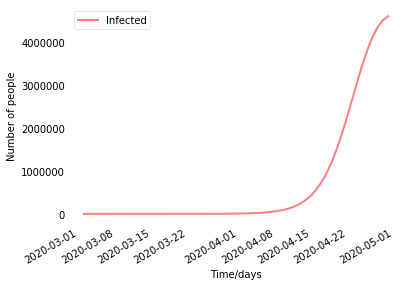

In [176]:
# We see from the cumulative infections graph above that in about 45 days total infected is about 120K
# With beta at 0.35 we see more than 100000 infections after 40 days BUT the rate of growth here is higher than seen
I0, R0 = 1,0
S0 = N - I0 - R0
t = np.linspace(0,60, 60)
beta, gamma = 0.35, 1./17
y0 = S0, I0, R0
ret = odeint(derivSIR, y0, t, args =(N, beta, gamma))
S, I, R = ret.T
plotCaseRate(False, True, False, False, start="03-02-2020t00:00")

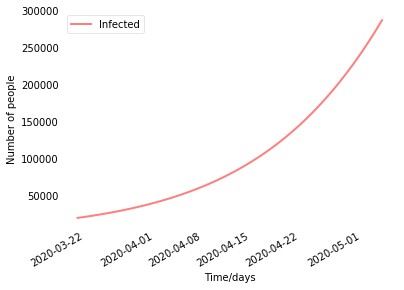

In [177]:
# With stats on 3/21, cumulative infected were 20595
# number of recovered guesstimated using 10% for closed and further 50% of that recovered
I0, R0 = 20595,1250
S0 = N - I0 - R0
t = np.linspace(0,45, 45)
beta, gamma = 0.12, 1./17
y0 = S0, I0, R0
ret = odeint(derivSIR, y0, t, args =(N, beta, gamma))
S, I, R = ret.T
plotCaseRate(False, True, False, False, start="03-21-2020t00:00")

Now with a growth rate of 0.12 this graph too shows the total infected about 30 days after 3/21 between 100K and 150K. This estimated infected in another 10 days or so by the end of April is a lot less at about 200K, although it still shows this curve increasing instead of levelling off. 

If you have suggestions on how to finetune this model to more accurately reflect how the curve is actually flattening, please let me know

Lets look next at a model that also includes the number of dead

## SIRD Model and Tuning

The SIRD or **S**usceptible - **I**nfectious - **R**ecovered - **D**ead Model is another epidemiologic model. <br>
It divides the total population **N** in 4 camps. <br>
* Susceptible individuals who may yet be infected
* Infectious individuals or carriers who are currently distributing the dosease
* Recovered individuals who have recovered and developed immunity
* Dead individuals who passed away after contracting the infection

The change in susceptible individuals and recovered individuals is calculated similar to the SIR model <br>

The change in dead individuals per unit time, is modeled by <br>
> dDdt = *mu I* <br>
where mu is the death rate determined as 1/ #number of days after infection that death occurs <br>

The change in infectious individuals in unit time then is the sum of the newly infected minus the newly recovered and minus the newly dead <br>
> dIdt = *beta S I /N - gamma I - mu I* <br>

Here to get mu values we use two methods:
    1. From reports that among patients who have died, the time from symptom onset to outcome ranges from 2-8 weeks, and we took an average of 5 weeks and 
    2. from a reference paper "Data-based analysis, modelling and forecasting of the COVID-19 outbreak" that models the COVID outbreak using SIRD and has different solutions for the parameters used



In [179]:
def derivSIRD(y, t, N, beta, gamma, mu):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dIdt, dRdt, dDdt

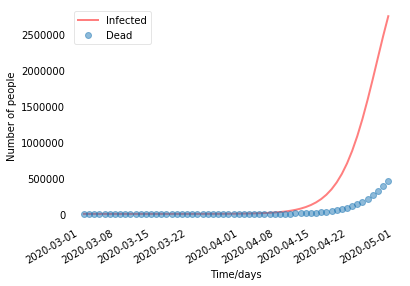

In [181]:
# Adding death numbers to the first model we tried with SIR starting beginning March
# mu estimated at average mrtality after 5 weeks
I0, R0, D0 = 1,0, 0
S0 = N - I0 - R0 - D0
t = np.linspace(0,60, 60)
beta, gamma = 0.35, 1./17
mu = 1./35
y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(N, beta, gamma, mu))
S, I, R, D = ret.T
plotCaseRate(False, True, False, True)

By adding the modelling for dead, it appears that the estimated infected seems to be in the mid 100K in Mid April while dead increases significantly more by end April. More importantly, both these curves seem to be increasing too rapidly for the cumulative curves we are seeing now

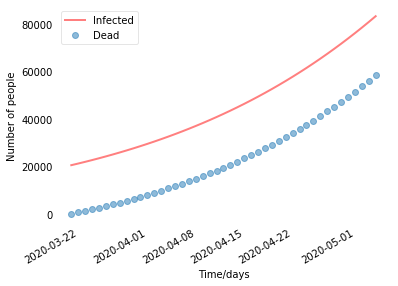

In [183]:
# Adding death numbers to the second model for SIR starting about 3/21
I0, R0, D0 = 20595,1250,158
S0 = N - I0 - R0 - D0
t = np.linspace(0,45, 45)
beta, gamma = 0.12, 1./17
mu = 1./35
y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(N, beta, gamma, mu))
S, I, R, D = ret.T
plotCaseRate(False, True, False, True,start="03-21-2020t00:00")

Here by adding the modelling for dead, it appears that the estimated infected is too low and dead too high here. <br> 
We use the parameters from reference that is based on an assumption of underreporting of cases that are mild

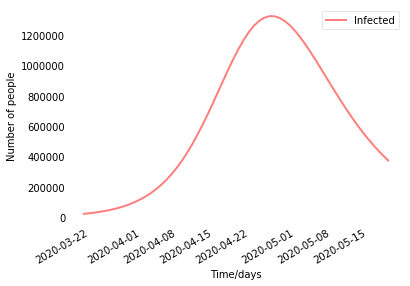

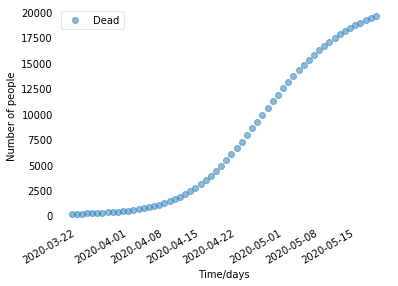

In [225]:
# beta, gamma, mu from reference
I0, R0, D0 = 20595,1250,158
S0 = N - I0 - R0 - D0
t = np.linspace(0,60, 60)
beta, gamma = 0.319, 0.16
mu = 0.0005
y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(N, beta, gamma, mu))
S, I, R, D = ret.T
plotCaseRate(False, True, False, False,start="03-21-2020t00:00")
plotCaseRate(False, False, False, True,start="03-21-2020t00:00")

While the number dead seems to lag cumulative death counts a little, this model appears to be closer than the previous one that overestimated deaths. Interestingly, there are a couple of serology studies out in LA that have also similarly found that the number of infected and recovered greatly overexceed documented values. <br> 
Finally we extend this model out for a year.

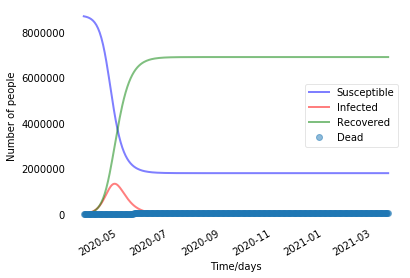

In [228]:
# beta, gamma, mu from reference
I0, R0, D0 = 20595,1250,158
S0 = N - I0 - R0 - D0
t = np.linspace(0,365, 365)
beta, gamma = 0.319,0.16
mu = 0.0005
y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(N, beta, gamma, mu))
S, I, R, D = ret.T
plotCaseRate(True, True, True, True,start="03-21-2020t00:00")

## References
    1. SIR Model in Python - https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    2. Gamma estimation via number of days for recovery - https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf
    3. Mu estimation via number of days for death - https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf
    4. Unacast social distancing scorecard - https://www.unacast.com/covid19/social-distancing-scoreboard?view=state&fips=36
    5. SIRD Covid 19 estimate's for China/Italy and parameter estimation - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0230405
    6. LA Serology study - https://news.usc.edu/168987/antibody-testing-results-covid-19-infections-los-angeles-county/